In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, f1_score

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam

from IPython.display import display

import re
from textwrap import wrap

from time import time

from seaborn import heatmap

from scipy.stats import t

# Data set description
[UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Parkinson+Speech+Dataset+with++Multiple+Types+of+Sound+Recordings#)

Attribute Information:

Training Data File:
- column 1: Subject id
- colum 2-27: features
    - features 1-5: Jitter (local),Jitter (local, absolute),Jitter (rap),Jitter (ppq5),Jitter (ddp),
    - features 6-11: Shimmer (local),Shimmer (local, dB),Shimmer (apq3),Shimmer (apq5), Shimmer (apq11),Shimmer (dda),
    - features 12-14: AC,NTH,HTN,
    - features 15-19: Median pitch,Mean pitch,Standard deviation,Minimum pitch,Maximum pitch,
    - features 20-23: Number of pulses,Number of periods,Mean period,Standard deviation of period, 
    - features 24-26: Fraction of locally unvoiced frames,Number of voice breaks,Degree of voice breaks
- column 28: UPDRS
- column 29: class information

# Data preparation

### Cleaning and save

In [30]:
# col_names = ["id",
#              "jitter local", "jitter local abs", "jitter rap", "jitter ppq5", "jitter ddp",
#              "shimmer local", "shimmer local db", "shimmer apq3", "shimmer apq5", "shimmer apq11", "shimmer dda",
#              "ac", "nth", "htn",
#              "median pitch", "mean pitch", "standard deviation of pitch", "minimum pitch", "maximum pitch",
#              "number of pulses", "number of periods", "mean period", "standard deviation of period", 
#              "fraction of locally unvoiced frames", "number of voice breaks", "degree of voice breaks",
#              "updrs",
#              "class"]

# data_raw = pd.read_csv("data/raw_data.txt", header=None)
# data_raw.columns = col_names
# data = data_raw.drop(columns=["id", "updrs"])
# data.to_csv("data/processed_data.csv", index=False)

# X = data.drop("class", axis=1).values
# y = data["class"].values
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

# scaler = StandardScaler()
# scaler.fit(X_train)
# X_train = scaler.transform(X_train)
# X_val = scaler.transform(X_val)
# X_test = scaler.transform(X_test)

# np.savetxt("data/X_train.txt", X_train)
# np.savetxt("data/y_train.txt", y_train)
# np.savetxt("data/X_val.txt", X_val)
# np.savetxt("data/y_val.txt", y_val)
# np.savetxt("data/X_test.txt", X_test)
# np.savetxt("data/y_test.txt", y_test)

In [31]:
data = pd.read_csv("data/data.csv")
features = [col for col in data.columns if col.lower != "class"]
X_train = np.loadtxt("data/X_train.txt")
y_train = np.loadtxt("data/y_train.txt")
X_val = np.loadtxt("data/X_val.txt")
y_val = np.loadtxt("data/y_val.txt")
X_test = np.loadtxt("data/X_test.txt")
y_test = np.loadtxt("data/y_test.txt")

print(f'num train: {np.round(len(X_train) / len(data), 2)} ({len(X_train)})')
print(f'num val: {np.round(len(X_val) / len(data), 2)} ({len(X_val)})')
print(f'num test: {np.round(len(X_test) / len(data), 2)} ({len(X_test)})')

num train: 0.64 (665)
num val: 0.16 (167)
num test: 0.2 (208)


# Data visualisation

### Feature: summary statistics

In [32]:
summary_stats = data.drop("class", axis=1).describe().T[["mean", "std", "min", "25%", "75%", "max"]]
table = (summary_stats
         .applymap(lambda x: str(int(x)) if abs(x - int(x)) < 1e-6 else str(round(x, 2)))
         .to_latex(caption="Summary statistics", 
                   column_format='p{1.75cm}|p{0.60cm}|p{0.60cm}|p{0.60cm}|p{0.60cm}|p{0.60cm}|p{0.60cm}|p{0.60cm}'))
table = re.sub("\\\\begin{table}", "\\\\begin{table}[H]", table)
text_file = open(f'Tables/Summary statistics.txt', "w")
n = text_file.write(table)
text_file.close()
display(summary_stats)

,mean,std,min,25%,75%,max
jitter local,2.6795,1.7651,0.1900,1.5075,3.4115,14.3760
jitter local abs,0.0002,0.0001,0.0000,0.0001,0.0002,0.0008
jitter rap,1.2471,0.9795,0.0620,0.6170,1.6025,8.0160
jitter ppq5,1.3483,1.1387,0.0810,0.6658,1.6947,13.5420
jitter ddp,3.7412,2.9384,0.1850,1.8518,4.8085,24.0480
shimmer local,12.9184,5.4522,1.1850,9.3535,15.4932,41.1370
shimmer local db,1.1949,0.4201,0.1030,0.9410,1.4110,2.7210
shimmer apq3,5.6996,3.0152,0.4960,3.7030,6.9420,25.8200
shimmer apq5,7.9836,4.8409,0.7080,5.1603,9.5589,72.8600
shimmer apq11,12.2153,6.0163,0.5170,8.0795,15.3061,44.7640


### Features: density plots

In [33]:
for k in range(2):
    fig = plt.figure(figsize=(9, 9))
    for i in range(9):
        col = features[i + 9 * k]
        plt.subplot(3, 3, i + 1)
        plt.hist(data[col], density=True)
        plt.title("\n".join(wrap(col, 20)), fontsize=18)

    plt.tight_layout()
    fig.savefig(f"Images/density plots {9 * k + 1}-{9 * (k+1)}.pdf")
    plt.close()
    
fig = plt.figure(figsize=(9, 9))
for i in range(8):
    col = features[i + 18]
    plt.subplot(3, 3, i + 1)
    plt.hist(data[col], density=True)
    plt.title("\n".join(wrap(col, 20)), fontsize=18)
plt.tight_layout()
fig.savefig(f"Images/density plots {19}-{26}.pdf")
plt.close()

### Target

In [34]:
class_distribution = data.groupby("class").agg({"class": "count"}).rename(columns={"class": "count"})
table = class_distribution.to_latex(caption="Class distribution")
table = re.sub("\\\\begin{table}", "\\\\begin{table}[H]", table)
text_file = open(f'Tables/Class distribution.txt', "w")
n = text_file.write(table)
text_file.close()
display(class_distribution)

,count
class,
0,520
1,520


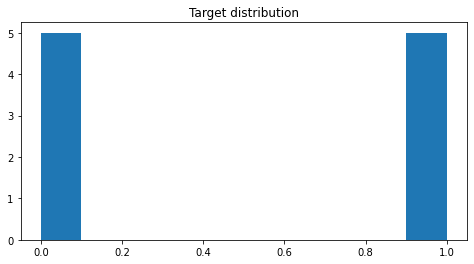

In [35]:
fig = plt.figure(figsize=(8, 4))
plt.title("Target distribution")
plt.hist(data["class"], density=True)
fig.savefig(f"Images/density plots target.pdf")
plt.show()
plt.close()

# Functions

### Evaluate performance function

In [43]:
def evaluate_performance(n_reps=10, optim="sgd", lr=0.01, mom=0.0,
                         n_hidden_layers=1, n_hidden_neurons=10, return_summary=True, verbose=False):
    """
    default lr and mom 
    """
    
    results = pd.DataFrame(
        columns=["Loss: train", "Loss: val", "Loss: test",
                 "Acc: train", "Acc: val", "Acc: test",
                 "Num epochs", "Time (s)"])
    
    for i in range(n_reps):
        if verbose:
            print(f"starting run {i + 1} out of {n_reps}")
        
        # specify model
        i = Input(shape=X_train[0].shape)
        x = Dense(n_hidden_neurons, activation="relu")(i)
        for _ in range(n_hidden_layers - 1):
            x = Dense(n_hidden_neurons, activation="relu")(x)
        o = Dense(1, activation='sigmoid')(x)
        model = Model(i, o)
        
        # define early stopping callback
        early_stopping_cb = EarlyStopping(patience=10, restore_best_weights=True)
        
        # define optimizer, loss function and metrics
        if optim == "sgd":
            optimizer = SGD(learning_rate=lr, momentum=mom)
        elif optim == "adam":
            optimizer = Adam()
            
        model.compile(optimizer=optimizer,
                      loss='BinaryCrossentropy',
                      metrics=['accuracy'])
        
        # fit model
        start = time()
        r = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                      epochs=300, verbose=False, callbacks=[early_stopping_cb])
        time_taken = time() - start
        
        # append results
        loss_train, acc_train = model.evaluate(X_train, y_train, verbose=False)
        loss_validation, acc_validation = model.evaluate(X_val, y_val, verbose=False)
        loss_test, acc_test = model.evaluate(X_test, y_test, verbose=False)
        
        row = pd.DataFrame({
            "Loss: train": [loss_train],
            "Loss: val": [loss_validation],
            "Loss: test": [loss_test],
            "Acc: train": [acc_train],
            "Acc: val": [acc_validation],
            "Acc: test": [acc_test],
            "Num epochs": [len(r.history["loss"])],
            "Time (s)": time_taken
        })
        results = results.append(row, ignore_index=True)
    
    results_summary = pd.DataFrame({
        "Mean": results.mean(),
        "Std. dev": results.std(),
        "CI: lower": results.mean() - t.ppf(0.975, n_reps - 1) * results.std() / np.sqrt(n_reps),
        "CI: upper": results.mean() + t.ppf(0.975, n_reps - 1) * results.std() / np.sqrt(n_reps)
    })
    results_summary[results_summary < 0] = 0
    
    if return_summary:
        return r, model, results, results_summary
    return r, model

### Write data functions

In [44]:
def write_table(results_summary, caption):
    table = (results_summary
             .applymap(lambda x: str(int(x)) if abs(x - int(x)) < 1e-6 else str(round(x, 4)))
             .to_latex(caption=caption, bold_rows=True))
    table = re.sub("\\\\begin{table}", "\\\\begin{table}[H]", table)
    text_file = open(f'Tables/{caption}.txt', "w")
    n = text_file.write(table)
    text_file.close()
    
def write_image(r, caption):
    fig = plt.figure(figsize=(8, 4))    
    
    plt.subplot(1, 2, 1)
    plt.title(f"Loss per iteration - {caption}")
    plt.plot(r.history['loss'], label='Loss')
    plt.plot(r.history['val_loss'], label='Validation Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.title(f"Accuracy per iteration - {caption}")
    plt.plot(r.history['accuracy'], label='Accuracy')
    plt.plot(r.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    
    plt.tight_layout()
    fig.savefig(f"Images/{caption}.pdf")
    plt.close()

### Sample usage

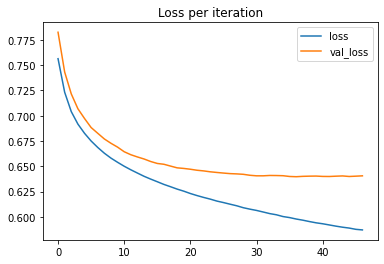

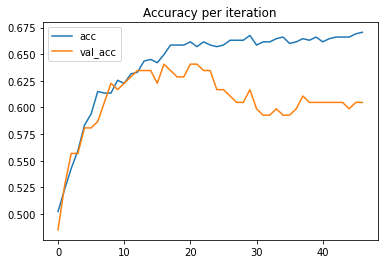

,Loss: train,Loss: val,Loss: test,Acc: train,Acc: val,Acc: test,Num epochs,Time (s)
0,0.6098,0.6233,0.6259,0.6451,0.6647,0.6106,69,4.7717
1,0.5879,0.6273,0.5976,0.6692,0.6467,0.6683,124,7.0286
2,0.5788,0.6172,0.6098,0.6962,0.6707,0.6587,93,5.5980
3,0.5785,0.5707,0.6052,0.6692,0.6886,0.6346,165,10.3920
4,0.5883,0.6405,0.6299,0.6586,0.6527,0.6202,89,5.0084
5,0.5742,0.6183,0.6055,0.6947,0.6766,0.6731,180,9.5466
6,0.5508,0.6185,0.6153,0.7128,0.6287,0.6635,163,8.7110
7,0.5812,0.6190,0.6252,0.6977,0.6467,0.6250,123,6.9574
8,0.5727,0.6181,0.5894,0.6782,0.6347,0.6779,203,10.7721
9,0.5960,0.6397,0.6358,0.6647,0.5988,0.6058,47,2.8072


,Mean,Std. dev,CI: lower,CI: upper
Loss: train,0.5818,0.0156,0.5513,0.6123
Loss: val,0.6193,0.0192,0.5816,0.6569
Loss: test,0.6139,0.0150,0.5845,0.6434
Acc: train,0.6786,0.0211,0.6373,0.7200
Acc: val,0.6509,0.0262,0.5996,0.7022
Acc: test,0.6438,0.0274,0.5900,0.6975
Num epochs,125.6000,51.3100,25.0325,226.1675
Time (s),7.1593,2.6536,1.9583,12.3603


In [9]:
r, model, results, results_summary = evaluate_performance()

plt.figure()
plt.title("Loss per iteration")
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

plt.figure()
plt.title("Accuracy per iteration")
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

display(results)
display(results_summary)

write_table(results_summary, "test")
write_image(r, "test")

# ADAM vs SGD

### SGD

In [10]:
r, model, results, results_summary = evaluate_performance(optim="sgd")
write_table(results_summary, "SGD")
write_image(r, "SGD")

### Adam

In [11]:
r, model, results, results_summary = evaluate_performance(optim="adam")
write_table(results_summary, "Adam")
write_image(r, "Adam")

# Learning and momentum rate

### Learning rate

In [12]:
r, model, results, results_summary = evaluate_performance(lr=0.01)
write_table(results_summary, "Learning rate = 0.01")
write_image(r, "Learning rate = 0.01")

In [13]:
r, model, results, results_summary = evaluate_performance(lr=0.10)
write_table(results_summary, "Learning rate = 0.10")
write_image(r, "Learning rate = 0.10")

In [14]:
r, model, results, results_summary = evaluate_performance(lr=0.50)
write_table(results_summary, "Learning rate = 0.50")
write_image(r, "Learning rate = 0.50")

In [15]:
r, model, results, results_summary = evaluate_performance(lr=1.00)
write_table(results_summary, "Learning rate = 1.00")
write_image(r, "Learning rate = 1.00")

In [16]:
r, model, results, results_summary = evaluate_performance(lr=5.00)
write_table(results_summary, "Learning rate = 5.00")
write_image(r, "Learning rate = 1.00")

### Momentum

In [17]:
r, model, results, results_summary = evaluate_performance(mom=0.01)
write_table(results_summary, "Momentum = 0.01")
write_image(r, "Momentum = 0.01")

In [18]:
r, model, results, results_summary = evaluate_performance(mom=0.10)
write_table(results_summary, "Momentum = 0.10")
write_image(r, "Momentum = 0.10")

In [19]:
r, model, results, results_summary = evaluate_performance(mom=0.50)
write_table(results_summary, "Momentum = 0.50")
write_image(r, "Momentum = 0.50")

In [20]:
r, model, results, results_summary = evaluate_performance(mom=1.00)
write_table(results_summary, "Momentum = 1.00")
write_image(r, "Momentum = 1.00")

# Number of hidden layers

In [21]:
r, model, results, results_summary = evaluate_performance(n_hidden_layers=1)
write_table(results_summary, "Hidden layers = 1")
write_image(r, "Hidden layers = 1")

In [22]:
r, model, results, results_summary = evaluate_performance(n_hidden_layers=2)
write_table(results_summary, "Hidden layers = 2")
write_image(r, "Hidden layers = 2")

In [23]:
r, model, results, results_summary = evaluate_performance(n_hidden_layers=3)
write_table(results_summary, "Hidden layers = 3")
write_image(r, "Hidden layers = 3")

In [24]:
r, model, results, results_summary = evaluate_performance(n_hidden_layers=4)
write_table(results_summary, "Hidden layers = 4")
write_image(r, "Hidden layers = 4")

# Number of hidden neurons

In [25]:
r, model, results, results_summary = evaluate_performance(n_hidden_neurons=5)
write_table(results_summary, "Hidden neurons = 5")
write_image(r, "Hidden neurons = 5")

In [26]:
r, model, results, results_summary = evaluate_performance(n_hidden_neurons=10)
write_table(results_summary, "Hidden neurons = 10")
write_image(r, "Hidden neurons = 10")

In [27]:
r, model, results, results_summary = evaluate_performance(n_hidden_neurons=15)
write_table(results_summary, "Hidden neurons = 15")
write_image(r, "Hidden neurons = 15")

In [28]:
r, model, results, results_summary = evaluate_performance(n_hidden_neurons=20)
write_table(results_summary, "Hidden neurons = 20")
write_image(r, "Hidden neurons = 20")

In [29]:
r, model, results, results_summary = evaluate_performance(n_hidden_neurons=25)
write_table(results_summary, "Hidden neurons = 25")
write_image(r, "Hidden neurons = 25")

# Best model

### Fit best model

In [56]:
# r, model, results, _ = evaluate_performance(optim="adam", n_hidden_layers=1, 
#                                                           n_hidden_neurons=20, n_reps=1)
# model.save("Models/best_model")
model = tf.keras.models.load_model("Models/best_model")
y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)
y_pred_test = model.predict(X_test)

In [57]:
display(results)

,Loss: train,Loss: val,Loss: test,Acc: train,Acc: val,Acc: test,Num epochs,Time (s)
0,0.5595,0.6113,0.5892,0.7113,0.6287,0.7115,36,2.8835


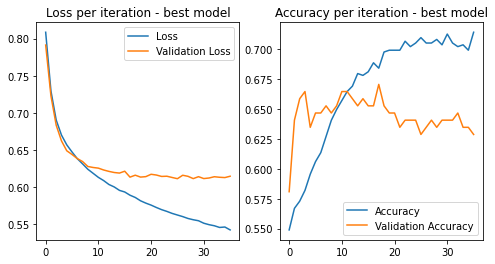

In [42]:
fig = plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title(f"Loss per iteration - best model")
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.title(f"Accuracy per iteration - best model")
plt.plot(r.history['accuracy'], label='Accuracy')
plt.plot(r.history['val_accuracy'], label='Validation Accuracy')
plt.legend()

### ROC and AUC

In [33]:
roc_train = roc_curve(y_train, y_pred_train)
roc_val = roc_curve(y_val, y_pred_val)
roc_test = roc_curve(y_test, y_pred_test)

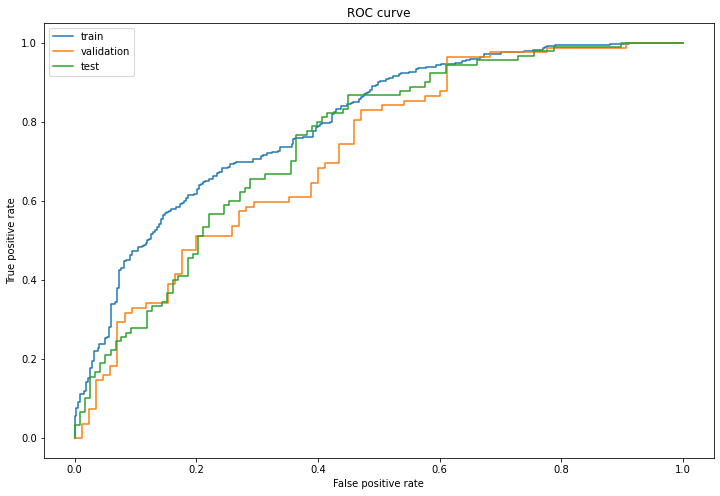

In [34]:
plt.figure(figsize=(12, 8))
plt.title("ROC curve")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.plot(roc_train[0], roc_train[1], label="train")
plt.plot(roc_val[0], roc_val[1], label="validation")
plt.plot(roc_test[0], roc_test[1], label="test")
plt.legend()
plt.show()

In [35]:
df_auc = pd.DataFrame({
    "train": roc_auc_score(y_train, y_pred_train),
    "validation": roc_auc_score(y_val, y_pred_val),
    "test": roc_auc_score(y_test, y_pred_test),
}, index=[0])

display(df_auc)

,train,validation,test
0,0.7947,0.7220,0.7468


### Confusion matrix

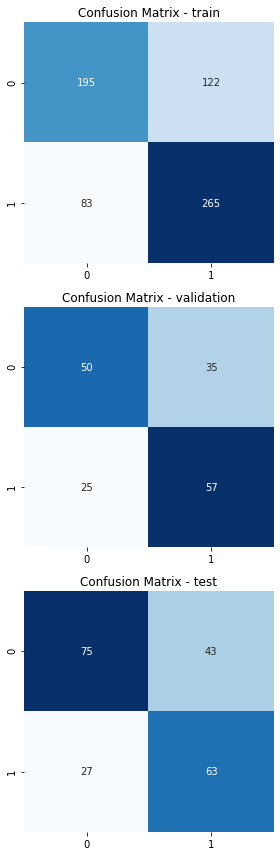

In [36]:
fig = plt.figure(figsize=(4, 12))
plt.subplot(3, 1, 1)

plt.title('Confusion Matrix - train')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')


heatmap(
    confusion_matrix(y_train, np.where(y_pred_train > 0.5, 1, 0)),
    annot=True, cmap='Blues', fmt="g", cbar=False)

plt.subplot(3, 1, 2)

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - validation')

heatmap(
    confusion_matrix(y_val, np.where(y_pred_val > 0.5, 1, 0)),
    annot=True, cmap='Blues', fmt="g", cbar=False)


plt.subplot(3, 1, 3)
plt.title('Confusion Matrix - test')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')


heatmap(
    confusion_matrix(y_test, np.where(y_pred_test > 0.5, 1, 0)),
    annot=True, cmap='Blues', fmt="g", cbar=False)

plt.tight_layout()

### Precision recall and f1 score

In [37]:
pr_train = precision_recall_curve(y_train, y_pred_train)
pr_val = precision_recall_curve(y_val, y_pred_val)
pr_test = precision_recall_curve(y_test, y_pred_test)

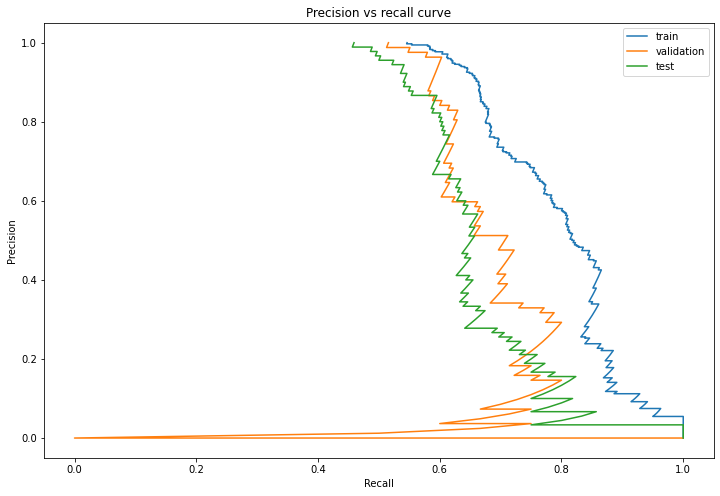

In [38]:
plt.figure(figsize=(12, 8))
plt.title("Precision vs recall curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.plot(pr_train[0], pr_train[1], label="train")
plt.plot(pr_val[0], pr_val[1], label="validation")
plt.plot(pr_test[0], pr_test[1], label="test")
plt.legend()
plt.show()

In [39]:
df_f1 = pd.DataFrame({
    "train": f1_score(y_train, np.where(y_pred_train > 0.5, 1, 0)),
    "validation": f1_score(y_val, np.where(y_pred_val > 0.5, 1, 0)),
    "test": f1_score(y_test, np.where(y_pred_test > 0.5, 1, 0)),
}, index=[0])

display(df_f1)

,train,validation,test
0,0.7211,0.6552,0.6429
